In [22]:
import mne
import matplotlib.pyplot as plt
import pickle
import pyxdf
import numpy as np

class EEG:
    def __init__(self):
        self.eeg_data = None

    def readEEG(self, file_path):
        # Read EEG data from XDF file format using pyxdf
        streams, header = pyxdf.load_xdf(file_path)
        eeg_streams = [s for s in streams if 'eeg' in s['info']['type'][0].lower()][0]
        if not eeg_streams:
            raise ValueError("No EEG data found in the XDF file.")
        
        return eeg_streams

In [28]:
# Example usage
eeg_instance = EEG()

# Read EEG data from XDF file
eeg_stream = eeg_instance.readEEG('1_0_0_Baseline.xdf')

In [29]:
len(eeg_stream['time_stamps'])

44904

In [30]:
time_stamps = eeg_stream['time_stamps']
print(f"\nShape of time stamps: {time_stamps.shape}")
print(f"First 5 time stamps: {time_stamps[:5]}")


Shape of time stamps: (44904,)
First 5 time stamps: [1033126.74307156 1033126.74407155 1033126.74507154 1033126.74607153
 1033126.74707152]


In [31]:
info = eeg_stream['info']

# Stream Name and Type
stream_name = info['name'][0]
stream_type = info['type'][0]
print(f"\nStream Name: {stream_name}")
print(f"Stream Type: {stream_type}")

# Channel Count and Format
channel_count = int(info['channel_count'][0])
channel_format = info['channel_format'][0]
print(f"Number of Channels: {channel_count}")
print(f"Channel Data Format: {channel_format}")

# Nominal Sampling Rate
nominal_srate = float(info['nominal_srate'][0])
effective_srate = info['effective_srate'] # This is directly available outside 'info'
print(f"Nominal Sampling Rate: {nominal_srate} Hz")
print(f"Effective Sampling Rate: {effective_srate:.2f} Hz")

# Channel Labels and Locations
channel_labels = []
channel_locations = {}

# The 'desc' field can sometimes be a list containing a defaultdict
if 'desc' in info and info['desc']:
    desc = info['desc'][0] # Access the first element if desc is a list
    if 'channels' in desc and desc['channels']:
        channels_info = desc['channels'][0] # Access the first element if channels is a list
        if 'channel' in channels_info:
            for ch in channels_info['channel']:
                label = ch['label'][0]
                channel_labels.append(label)
                if 'location' in ch and ch['location']:
                    loc = ch['location'][0]
                    # Convert coordinates to float, handling potential missing values
                    x = float(loc['X'][0]) if 'X' in loc and loc['X'][0] is not None else np.nan
                    y = float(loc['Y'][0]) if 'Y' in loc and loc['Y'][0] is not None else np.nan
                    z = float(loc['Z'][0]) if 'Z' in loc and loc['Z'][0] is not None else np.nan
                    channel_locations[label] = {'X': x, 'Y': y, 'Z': z}

print(f"\nChannel Labels ({len(channel_labels)} channels):")
print(channel_labels)

print("\nSample Channel Locations (Fp1, Fp2, Cz):")
print(f"Fp1: {channel_locations.get('Fp1')}")
print(f"Fp2: {channel_locations.get('Fp2')}")
print(f"Cz: {channel_locations.get('Cz')}")


Stream Name: EEG
Stream Type: EEG
Number of Channels: 34
Channel Data Format: float32
Nominal Sampling Rate: 1000.0 Hz
Effective Sampling Rate: 1000.01 Hz

Channel Labels (34 channels):
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'M1', 'M2', 'AFz', 'CPz', 'POz', 'AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'QuarW', 'QuarX', 'QuarY', 'QuarZ']

Sample Channel Locations (Fp1, Fp2, Cz):
Fp1: {'X': -27.0, 'Y': 86.0, 'Z': 36.0}
Fp2: {'X': 27.0, 'Y': 86.0, 'Z': 36.0}
Cz: {'X': 0.0, 'Y': 0.0, 'Z': 120.0}


In [26]:
'''
The `time_stamps` array contains LSL timestamps, which are absolute times. 
For plotting, it's often more intuitive to use *relative time* (time in seconds since the start of the recording).
Convert LSL timestamps to relative time in seconds
Subtract the first timestamp to start from 0 seconds

'''

relative_time = time_stamps - time_stamps[0]

print(f"First 5 relative time points: {relative_time[:5]} seconds")
print(f"Total recording duration: {relative_time[-1]:.2f} seconds")

First 5 relative time points: [0.         0.00099999 0.00199998 0.00299997 0.00399997] seconds
Total recording duration: 44.90 seconds


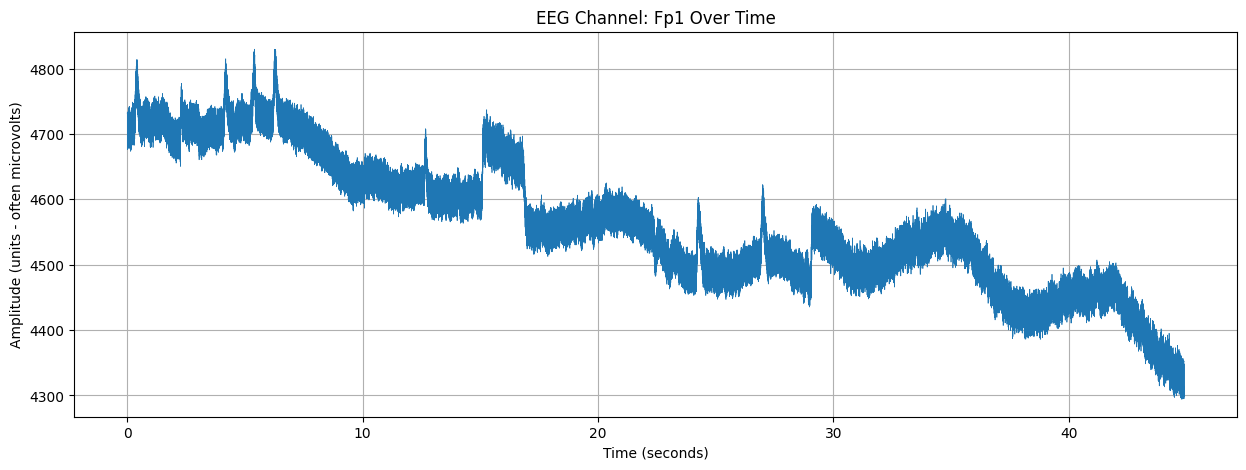

In [ ]:
'''
X-axis (Time): This represents the duration of your recording in seconds.

Y-axis (Amplitude): This is the raw voltage measured by the electrode. The units are typically microvolts (
muV), but without calibration information, we just refer to them as "units." 
You'll see the signal fluctuating up and down. These fluctuations are the "brain waves."

Wiggly Lines: EEG signals are inherently noisy and can look quite chaotic. 
You might see slow drifts, sharper spikes (artifacts), and rhythmic patterns.
'''

# Find the index of the 'Fp1' channel
eeg_data = eeg_stream['time_series']
try:
    fp1_index = channel_labels.index('Fp1')
    fp1_data = eeg_data[:, fp1_index]

    plt.figure(figsize=(15, 5))
    plt.plot(relative_time, fp1_data, lw=0.5) # lw is linewidth
    plt.title('EEG Channel: Fp1 Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (units - often microvolts)')
    plt.grid(True)
    plt.show()

except ValueError:
    print("Channel 'Fp1' not found in the channel labels.")
    print("Available channels:", channel_labels)

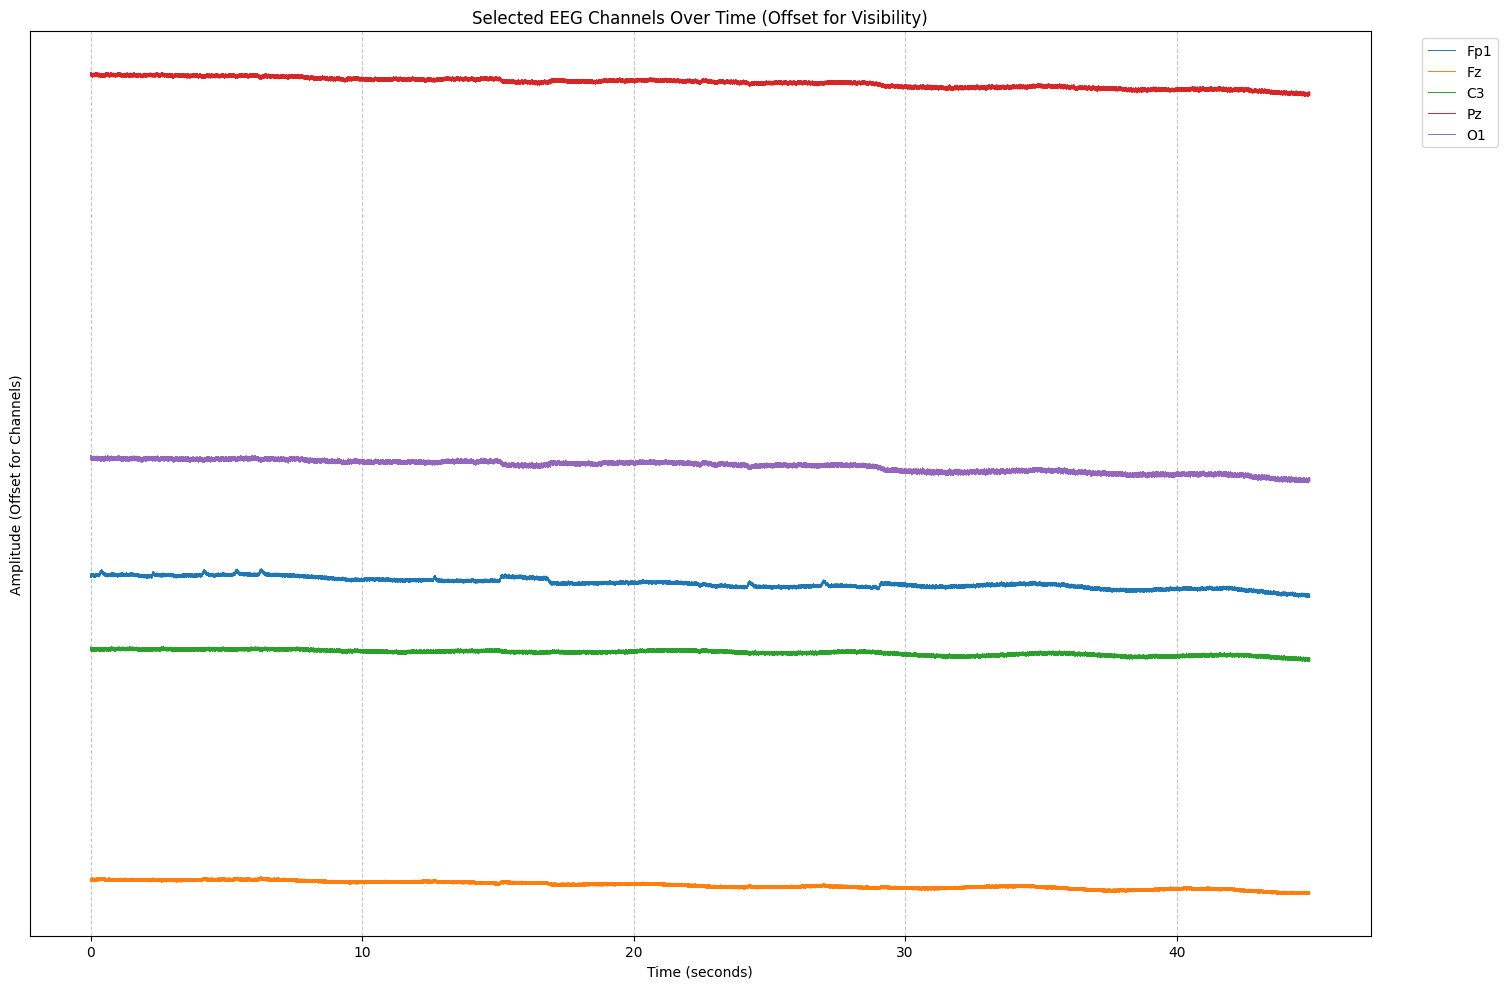

In [64]:
'''
Vertical Offset: Each channel is plotted at a different vertical position so their waveforms don't overlap, 
making it easier to see individual channel activity.

Channel Names: The legend indicates which line corresponds to which EEG electrode.

Differences Across Channels: You'll likely notice that the activity varies between channels. 
For example, frontal channels (like Fp1, Fz) might pick up more eye-related artifacts, while occipital 
channels (like O1, O2) are more sensitive to visual processing.

Artifacts: Look for large, sudden deflections. These are often artifacts - non-brain signals like 
muscle movements (e.g., blinking, clenching jaw), heartbeats, or electrical noise. Identifying and dealing 
with artifacts is a crucial part of EEG processing.
'''

# Select a few channels to plot (e.g., frontal, central, parietal, occipital)
selected_channels_to_plot = ['Fp1', 'Fz', 'C3', 'Pz', 'O1']
plot_indices = []
for ch_label in selected_channels_to_plot:
    try:
        plot_indices.append(channel_labels.index(ch_label))
    except ValueError:
        print(f"Warning: Channel '{ch_label}' not found, skipping.")

if not plot_indices:
    print("No selected channels found to plot.")
else:
    plt.figure(figsize=(15, 10))
    offset = 0  # Starting offset for the first channel
    vertical_spacing = 2000 # Adjust this value based on your data's amplitude to prevent overlap

    for i, idx in enumerate(plot_indices):
        channel_name = channel_labels[idx]
        channel_data = eeg_data[:, idx]

        # Plot the data with an offset
        plt.plot(relative_time, channel_data + offset, label=channel_name, lw=0.7)
        offset += vertical_spacing # Increase offset for the next channel

    plt.title('Selected EEG Channels Over Time (Offset for Visibility)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (Offset for Channels)')
    plt.yticks([]) # Hide Y-axis ticks as values are offset
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

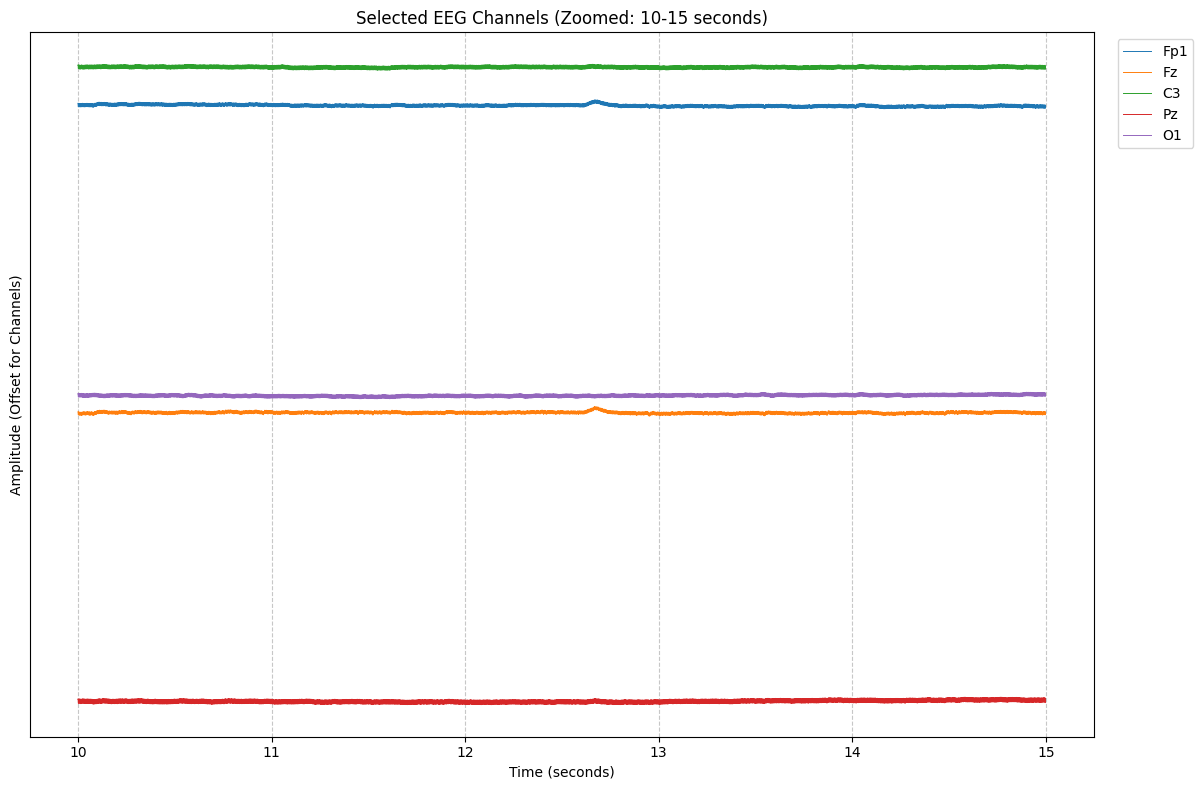

In [68]:
'''
Rhythmic Patterns: When zoomed in, you might start to discern more rhythmic patterns. 
These oscillations at different frequencies (e.g., alpha, beta, theta, delta) are key to 
understanding brain states and cognitive processes.

Fine Details: You'll notice small, rapid fluctuations that were indiscernible in the full recording.
'''

# Define the start and end time for the segment (in seconds)
start_time_sec = 10
end_time_sec = 15

# Find the corresponding indices in the relative_time array
start_idx = np.argmin(np.abs(relative_time - start_time_sec))
end_idx = np.argmin(np.abs(relative_time - end_time_sec))

# Slice the data and time for the selected window
time_window = relative_time[start_idx:end_idx]
eeg_window_data = eeg_data[start_idx:end_idx, :]

if not plot_indices:
    print("No selected channels found to plot in the time window.")
else:
    plt.figure(figsize=(12, 8))
    offset = 0
    vertical_spacing = 150 # Adjust as needed for the zoomed view

    for i, idx in enumerate(plot_indices):
        channel_name = channel_labels[idx]
        channel_data_window = eeg_window_data[:, i] # Use 'i' for sliced data

        plt.plot(time_window, channel_data_window + offset, label=channel_name, lw=0.7)
        offset += vertical_spacing

    plt.title(f'Selected EEG Channels (Zoomed: {start_time_sec}-{end_time_sec} seconds)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (Offset for Channels)')
    plt.yticks([])
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

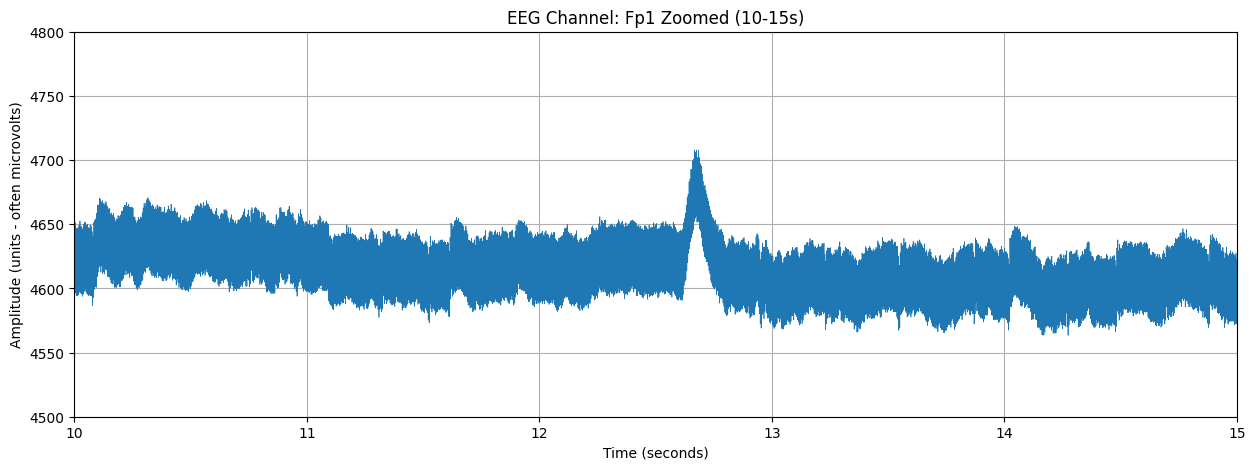

In [70]:
# Zooming in on a very short segment
### Method 1: Setting `xlim` and `ylim` directly

# Define the time window you want to zoom into (e.g., from 10 seconds to 15 seconds)
zoom_start_sec = 10
zoom_end_sec = 15

# Define the amplitude range you want to zoom into (optional, but helps with clarity)
# Look at your plot: Fp1 goes from ~4500 to ~4800. Let's try to narrow it down slightly.
zoom_min_amplitude = 4500
zoom_max_amplitude = 4800

plt.figure(figsize=(15, 5))
plt.plot(relative_time, fp1_data, lw=0.5) # Plot the full data first

# Set the x-axis limits (time)
plt.xlim(zoom_start_sec, zoom_end_sec)

# Set the y-axis limits (amplitude). This is optional but can make the waveform clearer.
plt.ylim(zoom_min_amplitude, zoom_max_amplitude)

plt.title(f'EEG Channel: Fp1 Zoomed ({zoom_start_sec}-{zoom_end_sec}s)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (units - often microvolts)')
plt.grid(True)
plt.show()

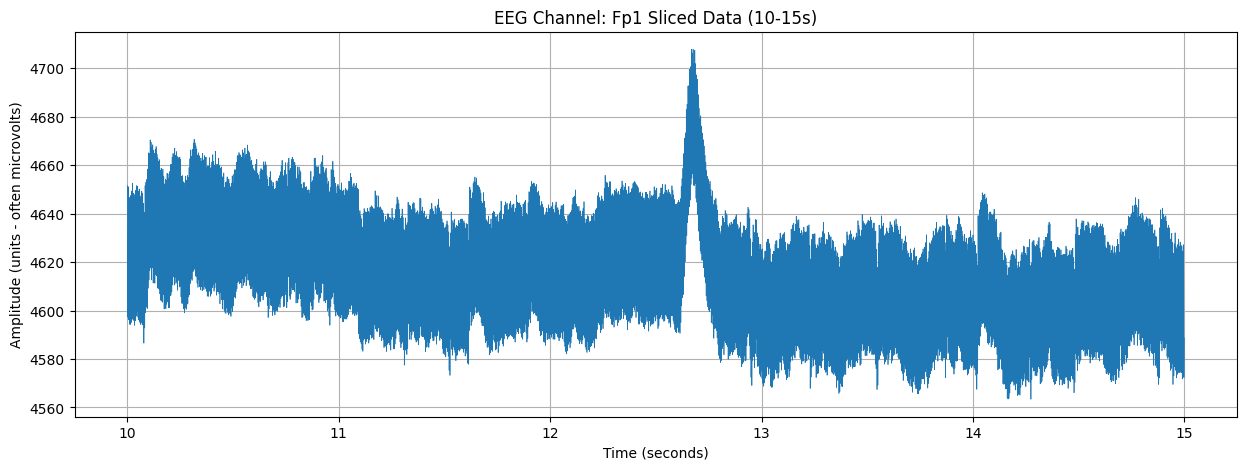

In [71]:
# Method 2: Slicing the data arrays

# Define the time window you want to zoom into
zoom_start_sec = 10
zoom_end_sec = 15

# Find the indices corresponding to the start and end times
# np.argmin(np.abs(array - value)) finds the index of the element closest to 'value'
start_idx = np.argmin(np.abs(relative_time - zoom_start_sec))
end_idx = np.argmin(np.abs(relative_time - zoom_end_sec))

# Slice the data arrays
zoomed_time = relative_time[start_idx:end_idx]
zoomed_fp1_data = fp1_data[start_idx:end_idx]

plt.figure(figsize=(15, 5))
plt.plot(zoomed_time, zoomed_fp1_data, lw=0.5)

plt.title(f'EEG Channel: Fp1 Sliced Data ({zoom_start_sec}-{zoom_end_sec}s)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (units - often microvolts)')
plt.grid(True)
plt.show()

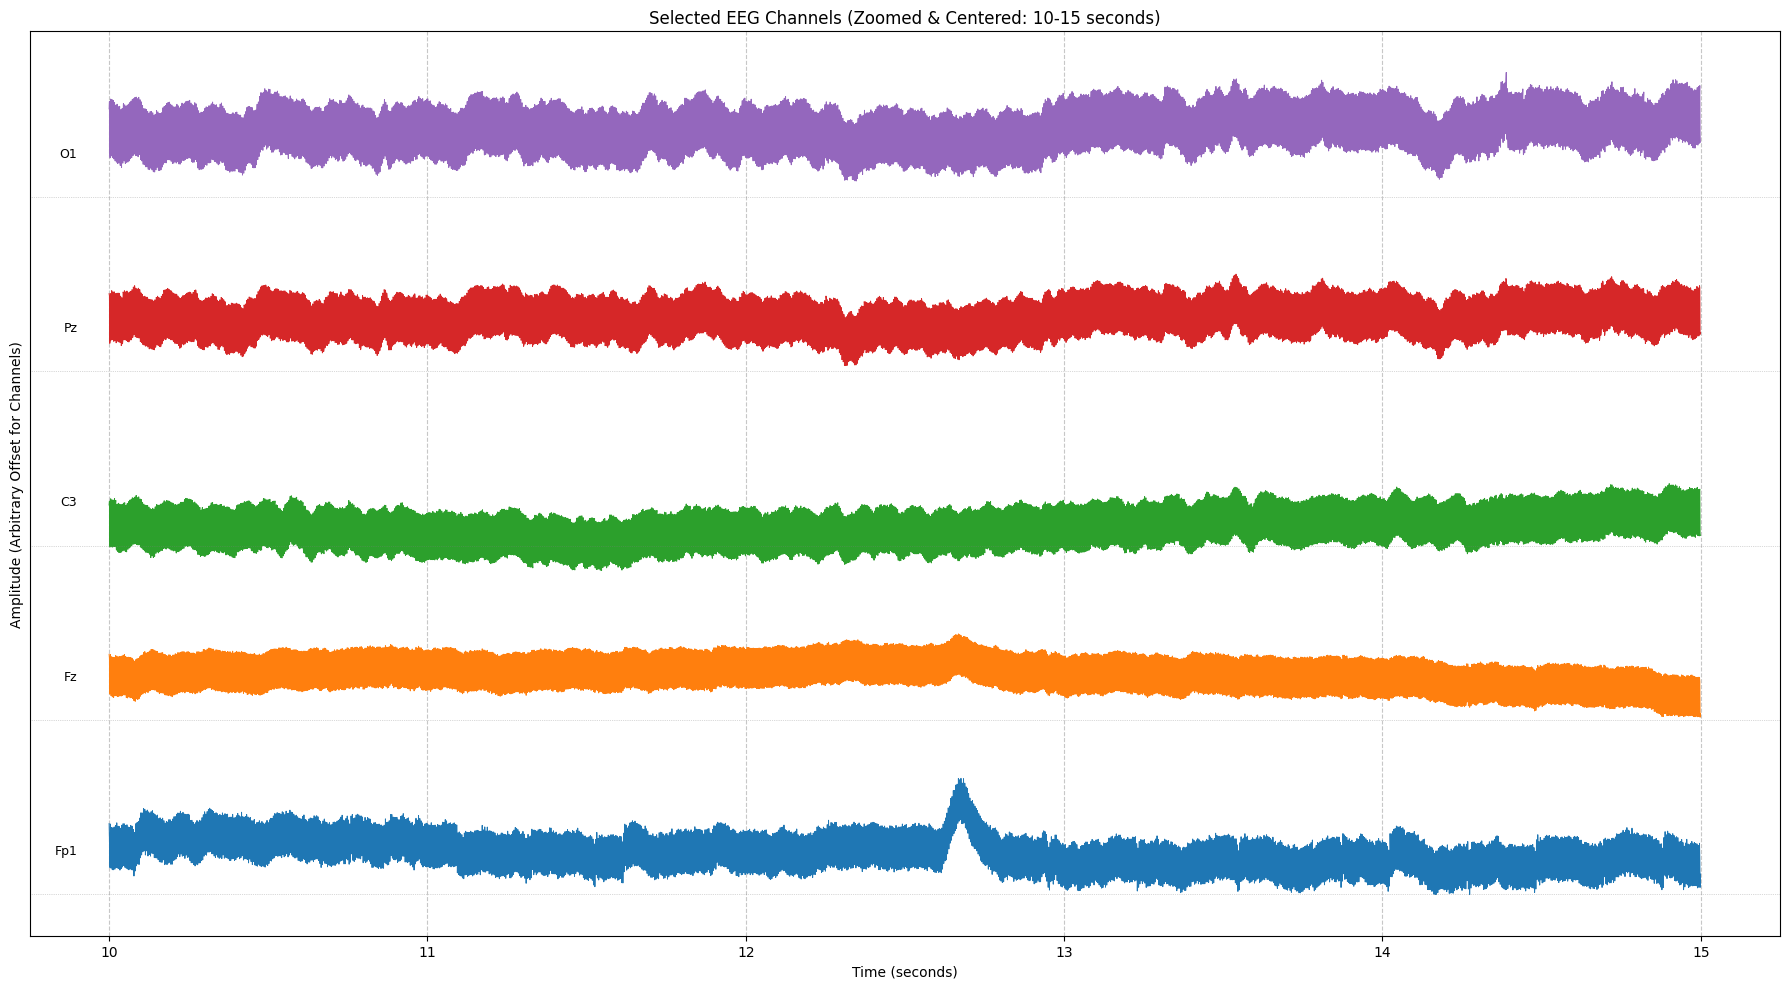

In [72]:
# --- Preprocessing Steps for Better Visualization ---

# 1. Remove DC Offset (Mean Removal):
# Subtract the mean of each channel to center the data around zero.
# This helps in visualizing the actual fluctuations without a huge offset.
eeg_data_centered = eeg_data - np.mean(eeg_data, axis=0)
# Note: For real EEG processing, you'd typically use a high-pass filter (e.g., at 0.1 or 0.5 Hz)
# to remove slow drifts, which is more robust than simple mean subtraction over long periods.

# Let's re-define the selected channels and slice the data for the time window
selected_channels_to_plot = ['Fp1', 'Fz', 'C3', 'Pz', 'O1']
plot_indices = []
for ch_label in selected_channels_to_plot:
    try:
        plot_indices.append(channel_labels.index(ch_label))
    except ValueError:
        print(f"Warning: Channel '{ch_label}' not found, skipping.")

# Define the time window for zooming
start_time_sec = 10
end_time_sec = 15

# Find the corresponding indices in the relative_time array
start_idx = np.argmin(np.abs(relative_time - start_time_sec))
end_idx = np.argmin(np.abs(relative_time - end_time_sec))

# Slice the *centered* data and time for the selected window
time_window = relative_time[start_idx:end_idx]
eeg_window_data_centered = eeg_data_centered[start_idx:end_idx, plot_indices]

# --- Improved Plotting ---

if not plot_indices:
    print("No selected channels found to plot in the time window.")
else:
    plt.figure(figsize=(18, 10))

    # Determine a more appropriate vertical spacing
    # A good heuristic is often a multiple of the typical peak-to-peak amplitude
    # For microvolts, 50-100 microvolts is a common visual spacing.
    # Given your raw scale, let's try a smaller spacing relative to your current numbers.
    # The amplitudes after centering seem to be in the range of +/- a few hundreds.
    # Let's estimate a reasonable visible range per channel.
    # Find the max peak-to-peak range in the window for a typical channel
    # (assuming the channels you picked have similar amplitude ranges)
    if eeg_window_data_centered.size > 0:
        # Get the range of the first plotted channel as a heuristic
        example_channel_range = np.max(eeg_window_data_centered[:, 0]) - np.min(eeg_window_data_centered[:, 0])
        vertical_spacing = example_channel_range * 1.5 # 1.5 times the range for a decent gap
        if vertical_spacing == 0: # Avoid division by zero if data is flat
            vertical_spacing = 100 # A default small value

    else:
        vertical_spacing = 100 # Default if no data

    offset = 0 # Starting offset

    for i, idx_in_original_data in enumerate(plot_indices):
        channel_name = channel_labels[idx_in_original_data]
        # Data is already sliced and selected in eeg_window_data_centered
        channel_data_window = eeg_window_data_centered[:, i]

        plt.plot(time_window, channel_data_window + offset, label=channel_name, lw=0.7)
        
        # Add a horizontal line to indicate the baseline of each channel
        # This helps in visually separating the channels
        plt.axhline(y=offset, color='gray', linestyle=':', linewidth=0.5, alpha=0.6)

        # Print the channel name on the left side of its trace
        # Adjust position slightly for better alignment
        text_y_position = offset + (vertical_spacing / 4) # Adjust label position
        plt.text(time_window[0] - 0.1, text_y_position, channel_name,
                 horizontalalignment='right', verticalalignment='center',
                 fontsize=9, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        offset += vertical_spacing # Increase offset for the next channel

    plt.title(f'Selected EEG Channels (Zoomed & Centered: {start_time_sec}-{end_time_sec} seconds)')
    plt.xlabel('Time (seconds)')
    # plt.ylabel('Amplitude (microvolts, relative to channel mean)') # More descriptive label
    plt.yticks([]) # Still hide Y-axis ticks, as values are offset
    plt.ylabel('Amplitude (Arbitrary Offset for Channels)') # Updated for clarity
    
    # Hide the default legend as we're labeling directly on the plot
    # plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

The Concept: Frequency Analysis (Fourier Transform)
The most common method to break down an EEG signal into its constituent frequencies is the Fourier Transform.

Time Domain vs. Frequency Domain:

What you've been plotting so far is the signal in the time domain: Amplitude (voltage) as a function of time.

The Fourier Transform converts this into the frequency domain: Amplitude (or power) as a function of frequency. It tells you "how much" of each frequency is present in your signal.

EEG Frequency Bands: Once you're in the frequency domain, we look for energy within specific, well-defined frequency bands that are associated with different brain states and cognitive functions:

Delta (
delta): 0.5 - 4 Hz (deep sleep, some brain disorders, very young children)

Theta (
theta): 4 - 8 Hz (drowsiness, meditation, memory retrieval, early sleep stages)

Alpha (
alpha): 8 - 12 Hz (relaxed wakefulness, eyes closed, present over occipital/parietal regions)

Beta (
beta): 12 - 30 Hz (active thinking, alertness, problem-solving, anxious thought)

Gamma (
gamma): 30 - ~100+ Hz (higher-level cognitive processing, perception, learning; often very low amplitude and susceptible to muscle artifact)

Practical Steps for Frequency Analysis:
Preprocessing (Crucial!): Before applying a Fourier Transform, the data must be cleaned. The artifacts (blinks, muscle movements) and slow drifts (like the one you observed) contain a lot of energy across different frequencies, especially low frequencies. If you don't remove them, they will dominate your frequency spectrum and mask the true brain activity.

Detrending/High-pass filtering: To remove slow drifts/DC offset (e.g., filter above 0.5 Hz).

Low-pass filtering: To remove high-frequency noise and muscle artifacts (e.g., filter below 30-45 Hz for most analyses, or higher if interested in gamma).

Artifact Rejection/Correction: More advanced techniques to identify and remove or mitigate specific artifacts (e.g., independent component analysis (ICA) for eye blinks). For a beginner, simply avoiding segments with obvious large artifacts is a good start.

Choose a Segment of Data: Frequency analysis is typically performed on relatively short, "artifact-free" segments of data, often 1 to 5 seconds long. The length of the segment impacts the frequency resolution.

Apply Fourier Transform (e.g., FFT): The Fast Fourier Transform (FFT) is an efficient algorithm to compute the Discrete Fourier Transform.

Compute Power Spectrum: The result of the FFT is a complex array. To get the "amount" of each frequency, you typically compute the power spectrum (the squared magnitude of the FFT output). Power is often measured in 
muV 
2
 /Hz.

Average (Optional but Recommended): If you have multiple short segments (epochs) of data, you can compute the power spectrum for each segment and then average them. This helps to reduce noise and get a more stable estimate of the typical frequency content.

Visualize: Plot the power (Y-axis) against frequency (X-axis) for each channel.

/opt/anaconda3/envs/eeg/lib/python3.9/site-packages/scipy/signal/_signaltools.py:3602: RuntimeWarning: divide by zero encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/opt/anaconda3/envs/eeg/lib/python3.9/site-packages/scipy/signal/_signaltools.py:3602: RuntimeWarning: overflow encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef
/opt/anaconda3/envs/eeg/lib/python3.9/site-packages/scipy/signal/_signaltools.py:3602: RuntimeWarning: invalid value encountered in matmul
  newdata[sl] = newdata[sl] - A @ coef


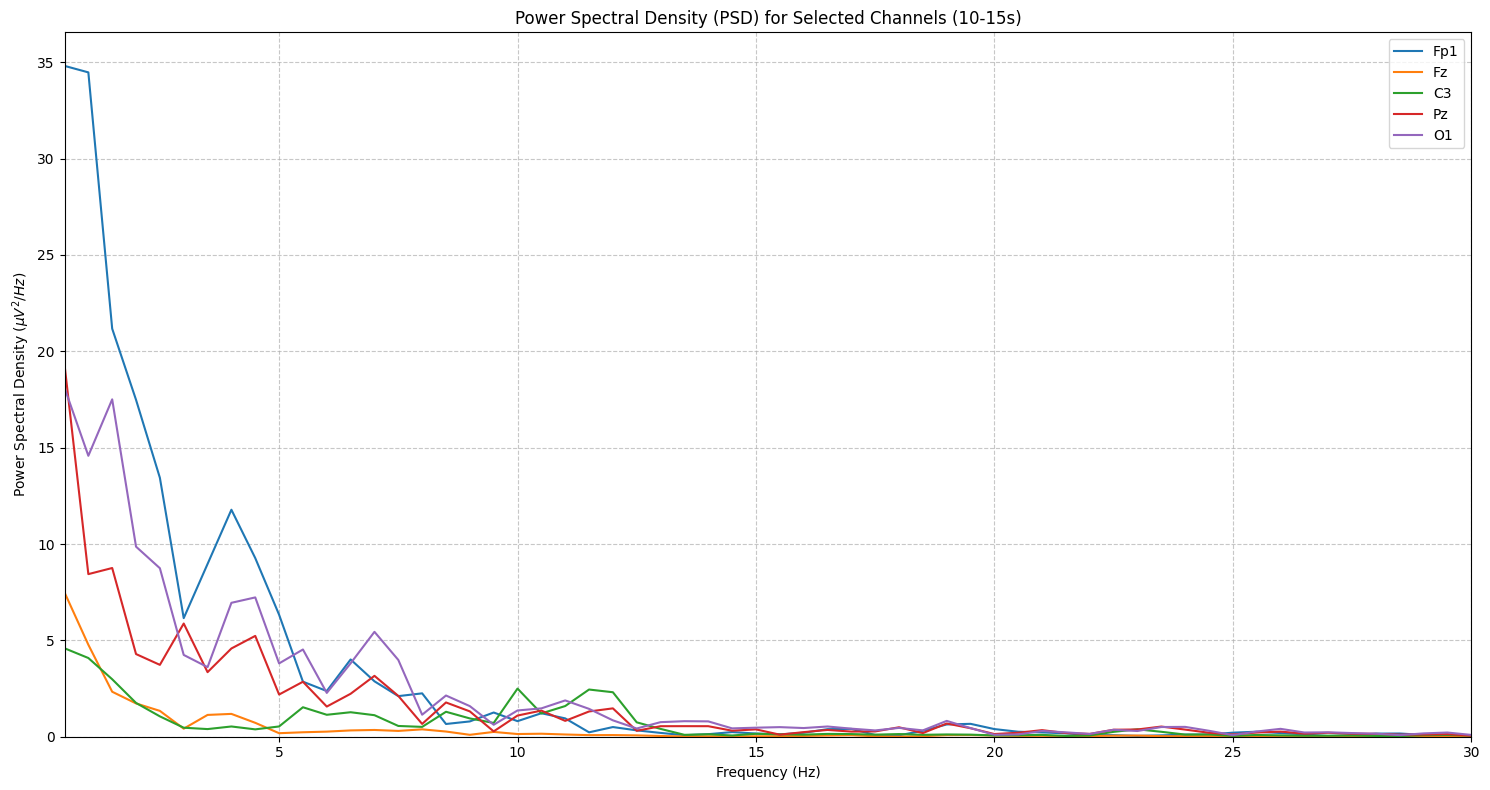


--- Interpreting the Power Spectral Density (PSD) Plot ---
Look for peaks or sustained high power in specific frequency ranges:
  - Delta (0.5-4 Hz): Very slow waves, dominant in deep sleep. Might see some here from residual low-frequency activity.
  - Theta (4-8 Hz): Drowsiness, meditation, memory processes.
  - Alpha (8-12 Hz): Relaxed wakefulness, often largest over posterior regions (O1, Pz) when eyes are closed.
  - Beta (12-30 Hz): Active thinking, alertness, muscle tension. Often present across most channels.
  - Gamma (30+ Hz): High-level cognition, very fast. More susceptible to muscle artifact.

What to look for in YOUR plot:
 - **Peaks:** A clear 'bump' in the curve indicates a strong presence of that frequency.
 - **Dominant Frequencies:** Which frequency band has the highest power for each channel?
 - **Channel Differences:** Do some channels (e.g., O1, Pz) show a stronger alpha peak than frontal channels (Fp1, Fz)?
 - **Noise:** High power at very low (<1 Hz) or very hig

In [73]:
from scipy import signal # For filtering and PSD

srate = float(eeg_stream['info']['nominal_srate'][0]) # Get sampling rate

# --- Preprocessing: Centering and Filtering ---

# 1. Remove DC Offset / Detrend
# Using detrend to remove linear trend, which is more robust than just mean subtraction for drifts.
eeg_data_detrended = signal.detrend(eeg_data, axis=0)

# 2. Band-pass Filter (e.g., 0.5 Hz to 45 Hz)
# This removes very slow drifts and high-frequency noise/muscle artifacts.
# Define filter parameters
lowcut = 0.5  # Hz (high-pass cutoff)
highcut = 45.0 # Hz (low-pass cutoff)
nyquist = 0.5 * srate # Nyquist frequency (half the sampling rate)

# Design the Butterworth filter
order = 4 # Filter order (can be adjusted, higher order means steeper rolloff)
b, a = signal.butter(order, [lowcut/nyquist, highcut/nyquist], btype='band')

# Apply the filter to each channel
eeg_data_filtered = signal.lfilter(b, a, eeg_data_detrended, axis=0)

# --- Select Channels and Time Window for Analysis ---
selected_channels_for_psd = ['Fp1', 'Fz', 'C3', 'Pz', 'O1'] # Same channels as before
psd_channel_indices = []
for ch_label in selected_channels_for_psd:
    try:
        psd_channel_indices.append(channel_labels.index(ch_label))
    except ValueError:
        print(f"Warning: Channel '{ch_label}' not found, skipping for PSD.")

# Choose a relatively clean segment for PSD calculation
# Let's pick a segment from your previous zoom window, assuming it's reasonably clean.
psd_start_sec = 10
psd_end_sec = 15

psd_start_idx = np.argmin(np.abs(relative_time - psd_start_sec))
psd_end_idx = np.argmin(np.abs(relative_time - psd_end_sec))

# Extract the filtered data for the chosen window and channels
eeg_segment_for_psd = eeg_data_filtered[psd_start_idx:psd_end_idx, psd_channel_indices]

### --- Power Spectral Density (PSD) Calculation ---

plt.figure(figsize=(15, 8))

# Iterate through selected channels to calculate and plot PSD
for i, ch_idx_original in enumerate(psd_channel_indices):
    channel_name = channel_labels[ch_idx_original]
    channel_data = eeg_segment_for_psd[:, i]

    # Use Welch's method for PSD estimation
    # NPERSEG: Length of each segment for Welch's method. A common choice is 2*srate for 2-second segments,
    # or a power of 2 like 2048 or 4096 for srate=1000. Larger NPERSEG gives better frequency resolution.
    # We'll use a segment length that's 2 seconds worth of data, or less if the total segment is shorter.
    nperseg = min(len(channel_data), int(2 * srate)) # Use 2 seconds or less if data is short

    # Compute PSD
    frequencies, psd = signal.welch(channel_data, fs=srate, nperseg=nperseg, scaling='density')

    # Plot the PSD for frequencies up to 30-50 Hz (where most relevant brain activity is)
    plt.plot(frequencies, psd, label=channel_name)

plt.title(f'Power Spectral Density (PSD) for Selected Channels ({psd_start_sec}-{psd_end_sec}s)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density ($\mu V^2 / Hz$)')
plt.xlim(0.5, 30) # Focus on typical EEG bands
plt.ylim(bottom=0) # Ensure Y-axis starts at 0
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# --- Identifying Waves from the PSD Plot ---

print("\n--- Interpreting the Power Spectral Density (PSD) Plot ---")
print("Look for peaks or sustained high power in specific frequency ranges:")
print("  - Delta (0.5-4 Hz): Very slow waves, dominant in deep sleep. Might see some here from residual low-frequency activity.")
print("  - Theta (4-8 Hz): Drowsiness, meditation, memory processes.")
print("  - Alpha (8-12 Hz): Relaxed wakefulness, often largest over posterior regions (O1, Pz) when eyes are closed.")
print("  - Beta (12-30 Hz): Active thinking, alertness, muscle tension. Often present across most channels.")
print("  - Gamma (30+ Hz): High-level cognition, very fast. More susceptible to muscle artifact.")

print("\nWhat to look for in YOUR plot:")
print(" - **Peaks:** A clear 'bump' in the curve indicates a strong presence of that frequency.")
print(" - **Dominant Frequencies:** Which frequency band has the highest power for each channel?")
print(" - **Channel Differences:** Do some channels (e.g., O1, Pz) show a stronger alpha peak than frontal channels (Fp1, Fz)?")
print(" - **Noise:** High power at very low (<1 Hz) or very high (>30 Hz) frequencies can indicate remaining artifacts or noise.")


In [77]:

from mne.datasets import misc

fname = "1_0_0_Baseline.xdf"
streams, header = pyxdf.load_xdf(fname)
data = streams[0]["time_series"].T
assert data.shape[0] == 5  # four raw EEG plus one stim channel
data[:4:2] -= data[1:4:2]  # subtract (rereference) to get two bipolar EEG
data = data[::2]  # subselect
data[:2] *= 1e-6 / 50 / 2  # uV -> V and preamp gain
sfreq = float(streams[0]["info"]["nominal_srate"][0])
info = mne.create_info(3, sfreq, ["eeg", "eeg", "stim"])
raw = mne.io.RawArray(data, info)
raw.plot(scalings=dict(eeg=100e-6), duration=1, start=14)

AttributeError: 'list' object has no attribute 'T'

In [78]:
streams

[{'info': defaultdict(list,
              {'name': ['PRST'],
               'type': ['Markers'],
               'channel_count': ['1'],
               'channel_format': ['string'],
               'source_id': ['Presentation on CS3024D00078917'],
               'nominal_srate': ['0.000000000000000'],
               'version': ['1.100000000000000'],
               'created_at': ['1029829.620333000'],
               'uid': ['0dcde1ab-4087-4cc9-9ead-6996720e6271'],
               'session_id': ['default'],
               'hostname': ['CS3024D00078917'],
               'v4address': [None],
               'v4data_port': ['16572'],
               'v4service_port': ['16572'],
               'v6address': [None],
               'v6data_port': ['16572'],
               'v6service_port': ['16572'],
               'desc': [defaultdict(list,
                            {'mode': ['Full'],
                             'timecreated': ['2023-03-27 16:03:35.472']})],
               'stream_id': 1,
      